# Kitchen20: an extention to ESC50


The Kitchen20 dataset is a freely available (Creative Commons Attribution-NonCommercial license) collection of short kitchen sounds recordings presented in a unified format (5-second-long clips, 44100 Hz, single channel, compressed @ 192 kbit/s). All clips have been extracted and manually labeled by the author from public field recordings available through bothe the Freesound.org project and diverse participant that agreed on recording specific sounds in their own kitchens.

- Kitchen20: a sound dataset with 800 environmental sounds (20 classes, 40 clips per class)
- ESC70: The concatenation of both ESC50 and Kitchen20

---

The goal of this project is to include specific sounds that would happen in a kitchen to a raw audio dataset of environmental sounds.

This notebook provides a glipse into data.

## Loading the Data:

In [1]:
import os
import shutil
import urllib
import zipfile
import glob
import pandas as pd
import numpy as np
import kitchen20
from kitchen20 import esc

dataset = esc.ESC70(folds=[1, 2, 3, 4, 5],
                    compute_features=True,
                    overwrite=False,
                    audio_rate=44100)

/media/moreaux-gpu/Data/Dataset/ESC-70/kitchen20/__init__.py
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...


In [2]:
def dataset_to_df(dataset):
    '''Get a dataframe out of the dataset.
    The dataframe contains MFCC's means and variance values over the full lenght
    of the sound on 13 different banks and the zero crossing rate mean and variance'''
    df  = pd.DataFrame()
    for idx, values in enumerate(zip(dataset.folds_nb, 
                                     dataset.labels, 
                                     dataset.mfcc, 
                                     dataset.zcr)):
        fold, label, mfcc, zcr = values
        row = pd.DataFrame([idx], columns=['idx'])
        row['fold'], row['category'] = fold, label

        # Compute mean and std of the banks in mfcc
        mfcc = mfcc[:, :]
        mfcc_mean = pd.DataFrame(np.mean(mfcc, axis=0)[1:]).T
        mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
        mfcc_std = pd.DataFrame(np.std(mfcc, axis=0)[1:]).T
        mfcc_std.columns = list('MFCC_{} std'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
        row = row.join(mfcc_mean)
        row = row.join(mfcc_std)

        # Compute mean and std of zcr
        row['ZCR mean'] = np.mean(zcr)
        row['ZCR std'] = np.std(zcr)

        df = df.append(row)
        
    return df

df = dataset_to_df(dataset)

## Confusion matrix code

In [3]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots(figsize=(10,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Bayesian process
find the best set of parameters with a bayesian process method

In [ ]:
import sklearn as sk
import sklearn.ensemble
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt
from sklearn.model_selection import cross_val_score


fStart = 'MFCC_1 mean'
fEnd = 'ZCR std'
nClasses = dataset.nClasses

def evaluate_algo(clf_params, compute_conf_mat=False):
    # Select the classifier type
    algo = clf_params['type']
    del clf_params['type']  # not a parameter of clf
    if algo == 'knn':
        clf = sk.neighbors.KNeighborsClassifier(**clf_params)
    elif algo == 'svm':
        clf = sk.svm.SVC(**clf_params)
    elif algo == 'randomforest':
        clf = sk.ensemble.RandomForestClassifier(**clf_params)
    
    # Apply classifier on all folds
    accs = 0
    all_conf_mat = np.zeros((nClasses, nClasses), dtype=int)
    for fold in range(1, 6):
        # Train/Test data
        train = df[df['fold'] != fold].copy()
        test = df[df['fold'] == fold].copy()
        
        # Fit classifier and retrieve test accuracy
        clf.fit(train.loc[:, fStart:fEnd], train['category'])
        test.loc[:, 'prediction'] = clf.predict(test.loc[:, fStart:fEnd])
        accs += np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        
        # Maybe compute confusion matrix
        if compute_conf_mat:
            conf_mat = sk.metrics.confusion_matrix(test['category'], test['prediction'])
            all_conf_mat = all_conf_mat + conf_mat
            
    # After 6 folds, return desired values
    if compute_conf_mat:
        return accs/5., all_conf_mat
    else:
        return accs/5.


def fix_space_dict(new_space, src_space):
    '''Adds missing values in new_space'''
    # Fix array items
    for k, v in src_space.items():
        if type(v) == hyperopt.pyll.base.Apply:
            if v.name == 'int':  # Fix int values
                new_space[k] = int(best[k])
            if v.name == 'switch':  # Fix array values
                idx = new_space[k] + 1
                new_space[k] = v.pos_args[idx].eval()
        if k not in new_space.keys():  # Fix missing values
            best[k] = v


def get_spaces():
    spaces = [
        {
            'type': 'knn',
            'n_neighbors': scope.int(hp.uniform('n_neighbors', 1, 400))},
        {
            'type': 'randomforest',
            'n_estimators': scope.int(hp.uniform('n_estimators', 1, 1000)),
            'max_features': scope.int(hp.uniform('max_features', 1, 10)),
            'max_depth': scope.int(hp.uniform('max_depth', 1, 20)),
            'criterion': hp.choice('criterion', ["gini", "entropy"]),
            'random_state': 1000},
        {
            'type': 'svm',
            'kernel': 'linear',
            'C': hp.uniform('C', 0, 10.0),
            'gamma': hp.uniform('gamma', 0, 20.0),
            'random_state': 1000},
        {
            'type': 'svm',
            'kernel': 'rbf',
            'C': hp.uniform('C', 0, 10.0),
            'gamma': hp.uniform('gamma', 0, 20.0),
            'random_state': 1000},
        {
            'type': 'svm',
            'kernel': 'poly',
            'C': hp.uniform('C', 0, 10.0),
            'gamma': hp.uniform('gamma', 0, 20.0),
            'random_state': 1000}]
    return spaces


def loss(clf_params):
    acc = evaluate_algo(clf_params)
    return {'loss': -acc, 'status': STATUS_OK}


def train_all_algo():
    spaces = get_spaces()
    bests = []
    print(df.shape)  # Hopefully the good df is seen...
    for clf_params in spaces:
        trials = Trials()
        best = fmin(fn=loss, space=clf_params, algo=tpe.suggest, max_evals=20, trials=trials)
        print('best: ', best)

        # Correct the best run dictionary
        best['type'] = space['type']
        fix_space_dict(best, space)
        bests.append(best)

        # Compute best parameter's confusion matrix
        accs, conf_mat = evaluate_algo(best, True)
        print(best, '-- acc: ', accs)
        plot_confusion_matrix(conf_mat, dataset.classes)
        plt.show()
    print(bests)
    return bests


train_all_algo()

bests = [{
             'type': 'knn',
             'n_neighbors': 10}, 
         {
             'type' 'randomforest'
             'n_estimators': 751,
             'max_features': 3,
             'max_depth': 14,
             'criterion': 'gini',
             'random_state': 1000},
         {
             'type' 'svm'
             'gamma': 11.705534324232854,
             'random_state': 1000, 'kernel':
             'linear',
             'C': 0.023103267871290203},
         {
             'type' 'svm'
             'gamma': 0.0029500466411409576,
             'random_state': 1000,
             'kernel': 'rbf',
             'C': 6.418506700986687},
         {
             'type' 'svm'
             'gamma': 18.931275234133686,
             'random_state': 1000,
             'kernel': 'poly',
             'C': 5.255931793623537}]

(2800, 29)
100%|██████████| 20/20 [00:10<00:00,  1.79it/s, best loss: -0.23142857142857146]

## Find best parameters by hand

In [5]:
import sklearn as sk
import sklearn.ensemble

df_results = pd.DataFrame(columns=['f1','f2','f3','f4','f5'])
features_start = 'MFCC_1 mean'
features_end = 'ZCR std'

def train_on(algo_name, train, test):
    # Choose classifier
    if algo_name.startswith('knn'):
        n_neighbors = int(algo_name.split('_')[1])
        classifier = sk.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif algo_name.startswith('RandomForest'):
        n_estimators = int(algo_name.split('_')[1])
        classifier = sk.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    
    elif algo_name.startswith('SVM'):
        c = float(algo_name.split('_')[1])
        kernel = algo_name.split('_')[2]
        classifier = sk.svm.SVC(C=c, kernel=kernel)
    
    else:
        print('Wrong algorithm name: ', algo_name)

    classifier.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = classifier.predict(test.loc[:, features_start:features_end])
    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    confusion_mat = sk.metrics.confusion_matrix(test['category'], test['prediction'])

    return accuracy, confusion_mat


def record_confusions(confusion_matrix, confusions, algo_name):
    if algo_name not in confusions.keys():
        print(algo_name, confusion_matrix.shape)
        confusions[algo_name] = np.zeros(confusion_matrix.shape, dtype=int)
    confusions[algo_name] = confusions[algo_name] + confusion_matrix
    return confusion


def train_5_folds(df):
    df_results = pd.DataFrame(columns=['f1','f2','f3','f4','f5'])
    confusions = {}
    for fold in range(1, 6):
        print('Training fold', fold)
        df_column = 'f{}'.format(fold)
        train = df[df['fold'] != fold].copy()
        test = df[df['fold'] == fold].copy()
    
        print('train knn')
        for i in range(1,13):
            df_line = algo_name = 'knn_{}'.format(i)
            accuracy, confusion_current = train_on(algo_name, train, test)
            df_results.loc[df_line, df_column] = accuracy
            confusions['{}_{}'.format(algo_name, fold)] = confusion_current

        print('train random forest')
        for i in [300, 400, 500, 600, 700]:
            df_line = algo_name = 'RandomForest_{}'.format(i)
            accuracy, confusion_current = train_on(algo_name, train, test)
            df_results.loc[df_line, df_column] = accuracy
            confusions['{}_{}'.format(algo_name, fold)] = confusion_current

        print('train svm')
        for k in ['linear', 'poly']:
            for i in [0.05, 0.1, 0.2, 0.5, 0.9, 1, 2, 10, 100]:
                df_line = algo_name = 'SVM_{}_{}'.format(i, k)
                accuracy, confusion_current = train_on(algo_name, train, test)
                df_results.loc[df_line, df_column] = accuracy
                confusions['{}_{}'.format(algo_name, fold)] = confusion_current

    print('Finished')
    return df_results, confusions

---
## Compute all datasets' results

In [6]:
datasets = [esc.ESC70(folds=[1, 2, 3, 4, 5],
                      compute_features=True,
                      audio_rate=44100),
            esc.ESC50(folds=[1, 2, 3, 4, 5],
                      compute_features=True,
                      audio_rate=44100),
            esc.ESC10(folds=[1, 2, 3, 4, 5],
                      compute_features=True,
                      audio_rate=44100),
            esc.Kitchen20(folds=[1, 2, 3, 4, 5],
                          compute_features=True,
                          audio_rate=44100)]

loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...


In [9]:
from IPython.display import display

dfs = []
for dataset in datasets:
    print('--', dataset.__class__.__name__)
    df = dataset_to_df(dataset)
    df_results, confusions = train_5_folds(df)
    df_results['average'] = df_results.mean(axis=1)
    display(df_results)
    dfs.append(df_results)

ESC70
Training fold 1
train knn
train random forest
train svm
Training fold 2
train knn
train random forest
train svm
Training fold 3
train knn
train random forest
train svm
Training fold 4
train knn
train random forest
train svm
Training fold 5
train knn
train random forest
train svm
Finished


,f1,f2,f3,f4,f5,average
knn_1,0.210714,0.223214,0.217857,0.266071,0.242857,0.232143
knn_2,0.171429,0.189286,0.217857,0.246429,0.233929,0.211786
knn_3,0.189286,0.176786,0.242857,0.232143,0.228571,0.213929
knn_4,0.191071,0.183929,0.230357,0.242857,0.235714,0.216786
knn_5,0.201786,0.196429,0.232143,0.253571,0.208929,0.218571
knn_6,0.207143,0.192857,0.248214,0.251786,0.217857,0.223571
knn_7,0.207143,0.2,0.257143,0.235714,0.230357,0.226071
knn_8,0.196429,0.219643,0.248214,0.244643,0.228571,0.227500
knn_9,0.207143,0.221429,0.2375,0.241071,0.246429,0.230714
knn_10,0.208929,0.230357,0.246429,0.242857,0.246429,0.235000


ESC50
Training fold 1
train knn
train random forest
train svm
Training fold 2
train knn
train random forest
train svm
Training fold 3
train knn
train random forest
train svm
Training fold 4
train knn
train random forest
train svm
Training fold 5
train knn
train random forest
train svm
Finished


,f1,f2,f3,f4,f5,average
knn_1,0.265,0.2575,0.275,0.3025,0.2675,0.2735
knn_2,0.23,0.265,0.27,0.2875,0.255,0.2615
knn_3,0.215,0.2325,0.2875,0.2875,0.245,0.2535
knn_4,0.23,0.2475,0.2675,0.28,0.23,0.2510
knn_5,0.2375,0.2525,0.2875,0.3,0.24,0.2635
knn_6,0.245,0.265,0.295,0.315,0.2425,0.2725
knn_7,0.23,0.265,0.2975,0.3075,0.2475,0.2695
knn_8,0.24,0.27,0.29,0.32,0.2625,0.2765
knn_9,0.2375,0.2775,0.2875,0.2975,0.2725,0.2745
knn_10,0.245,0.265,0.28,0.3125,0.255,0.2715


ESC10
Training fold 1
train knn
train random forest
train svm
Training fold 2
train knn
train random forest
train svm
Training fold 3
train knn
train random forest
train svm
Training fold 4
train knn
train random forest
train svm
Training fold 5
train knn
train random forest
train svm
Finished


,f1,f2,f3,f4,f5,average
knn_1,0.6,0.5375,0.6,0.5,0.6,0.5675
knn_2,0.6,0.575,0.6125,0.5375,0.5875,0.5825
knn_3,0.5,0.5875,0.5875,0.5875,0.6125,0.5750
knn_4,0.5875,0.625,0.5875,0.575,0.625,0.6000
knn_5,0.5625,0.575,0.575,0.575,0.6,0.5775
knn_6,0.5625,0.55,0.5875,0.575,0.6375,0.5825
knn_7,0.5625,0.6,0.5875,0.6,0.625,0.5950
knn_8,0.525,0.5875,0.6,0.575,0.65,0.5875
knn_9,0.55,0.5625,0.575,0.5875,0.6625,0.5875
knn_10,0.525,0.5625,0.6125,0.575,0.65,0.5850


Kitchen20
Training fold 1
train knn
train random forest
train svm
Training fold 2
train knn
train random forest
train svm
Training fold 3
train knn
train random forest
train svm
Training fold 4
train knn
train random forest
train svm
Training fold 5
train knn
train random forest
train svm
Finished


,f1,f2,f3,f4,f5,average
knn_1,0.30625,0.3125,0.35,0.375,0.41875,0.35250
knn_2,0.28125,0.25625,0.35,0.375,0.41875,0.33625
knn_3,0.3125,0.2875,0.34375,0.3625,0.43125,0.34750
knn_4,0.3375,0.25625,0.36875,0.375,0.475,0.36250
knn_5,0.30625,0.30625,0.33125,0.36875,0.41875,0.34625
knn_6,0.29375,0.29375,0.325,0.39375,0.4125,0.34375
knn_7,0.3125,0.2875,0.36875,0.35,0.425,0.34875
knn_8,0.29375,0.30625,0.35,0.38125,0.41875,0.35000
knn_9,0.3125,0.29375,0.3625,0.33125,0.4125,0.34250
knn_10,0.2625,0.3,0.35,0.3375,0.40625,0.33125


-- ESC70


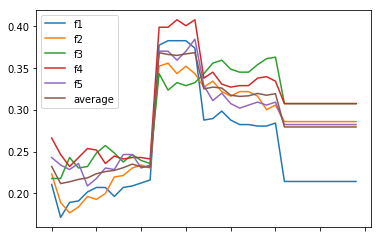

-- ESC50


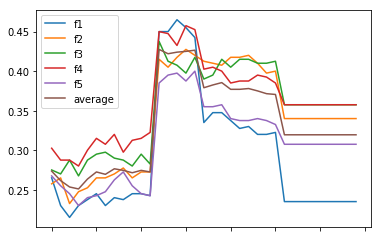

-- ESC10


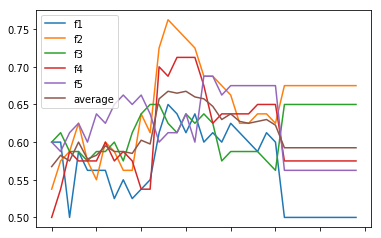

-- Kitchen20


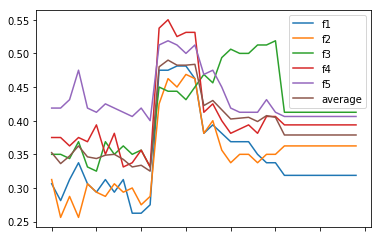

<built-in function all>


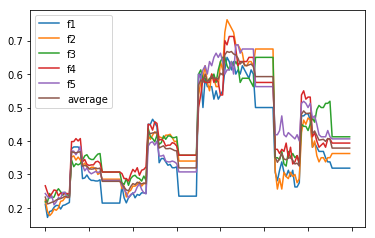

In [16]:
for df, ds in zip(dfs, datasets):
    print('--', ds.__class__.__name__)
    df.plot(); plt.show()

print(all)
df = pd.concat(dfs)
df.plot(); plt.show()

In [ ]:
bests = {}
for dataset in datasets:
    ds_name = dataset.__class__.__name__
    print(ds_name)
    df = dataset_to_df(dataset)
    bests[ds_name] = train_all_algo()